
## PGE 383 Model Generalization and Overfit

#### Angela Luciano
#### Energy and Earth Resources, Jackson School of Geosciences

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)


### Executive Summary

Training a good model is effective when it can be generalized to data it has not yet seen. In the end, however, it will only be as good as the data available. For example, if production data was available from just one location with similar reservoir characteristics, it will be difficult to generalize any model from that dataset  to predict performance elsewhere because it is not representative of a large range of possibilities. As shown in this workflow, training on low production data will underestimate, and training on high production data will overestimate production predictions, indicating an overfit to the model. To mitigate this issue, the modeler needs to both understand the limitations of the data available and know how to make up for the lack of data either by using analogous data or other information. 


### Import Packages

In [1]:
import numpy as np                                          # arrays and matrix math
import pandas as pd                                         # DataFrames
import math                                                 # math operations
import matplotlib.pyplot as plt                             # for plotting
from sklearn import metrics                                 # for MSE calc
from sklearn.ensemble import RandomForestRegressor          # random forest
cmap = plt.cm.inferno                                       # color map
import warnings                                             # ignore warnings
warnings.filterwarnings('ignore')

### Functions

The following functions will be used in the workflow.

In [2]:
# fits a random forest fit on 20% of dataset (out of 1000) that were sorted based off production quality
def production(productionwindow):
    if productionwindow==1:                                    #train on low production values only, first 200 values(20%) 
        X_train = X.iloc[0:200]; X_test =  X.iloc[200:]      
        y_train = y.iloc[0:200]; y_test = y.iloc[200:]
        print('Window 1: Train on lowest production values')
    elif productionwindow==2:                                  #train on next 200 values
        X_train = X.iloc[200:400]; X_test =  pd.concat([X.iloc[0:200],X.iloc[400:]])
        y_train = y.iloc[200:400]; y_test = pd.concat([y.iloc[0:200],y.iloc[400:]])
        print('Window 2: Train on low-med production')
    elif productionwindow==3:                                  #train on next 200 values
        X_train = X.iloc[400:600]; X_test =  pd.concat([X.iloc[0:400],X.iloc[600:]])
        y_train = y.iloc[400:600]; y_test = pd.concat([y.iloc[0:400],y.iloc[600:]])
        print('Window 3: Train on medium production values')
    elif productionwindow==4:                                  #train on next 200 values
        X_train = X.iloc[600:800]; X_test =  pd.concat([X.iloc[0:600],X.iloc[800:]])
        y_train = y.iloc[600:800]; y_test = pd.concat([y.iloc[0:600],y.iloc[800:]])
        print('Window 4: Train on med-high production')
    elif productionwindow==5:                                  #train on high production values only, last 200 values
        X_train = X.iloc[800:]; X_test =  X.iloc[0:800]
        y_train = y.iloc[800:]; y_test = y.iloc[0:800]
        print('Window 5: Train on highest production values')
    else:
        print("pick a value between 1-5 for low-high production ranges")
    
    #fit a random forest
    forest = RandomForestRegressor(max_depth=10, random_state=2,n_estimators=100)
    forest.fit(X_train,y_train)
    
    return X_train, X_test, y_train, y_test, forest

The following code block is from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_EnsembleTrees.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_EnsembleTrees.ipynb).
(with very minor edits) and was used for plots

In [3]:
# plots the data points and the decision tree prediction 
def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,):
    cmap = plt.cm.inferno
    xplot_step = (x_max - x_min)/300.0; yplot_step = (y_max - y_min)/300.0 # resolution of the model visualization
    xx, yy = np.meshgrid(np.arange(x_min, x_max, xplot_step), # set up the mesh
                     np.arange(y_min, y_max, yplot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])      # predict with our trained model over the mesh
    Z = Z.reshape(xx.shape)
    im = plt.imshow(Z,interpolation = None,aspect = "auto",extent = [x_min,x_max,y_min,y_max], vmin = z_min, vmax = z_max,cmap = cmap)
    if (type(xfeature) != str) & (type(yfeature) != str):
        plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=1.0, linewidths=0.6, edgecolors="white")
        plt.xlabel(xfeature.name); plt.ylabel(yfeature.name)
    else:
        plt.xlabel(xfeature); plt.ylabel(yfeature)
    plt.title(title)                                       # add the labels
    plt.xlim([x_min,x_max]); plt.ylim([y_min,y_max])
    cbar = plt.colorbar(im, orientation = 'vertical')      # add the color bar
    if type(response) == str:
        cbar.set_label(response, rotation=270, labelpad=20)        
    else:
        cbar.set_label(response.name, rotation=270, labelpad=20)
    return Z

# plots the estimated vs. the actual  
def check_model(model,xfeature,yfeature,response,title):    
    predict_train = model.predict(np.c_[xfeature,yfeature])
    plt.scatter(response,predict_train,s=None, c='red',marker=None, cmap=cmap, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim(0,10000); plt.ylim(0,10000)
    plt.arrow(0,0,10000,10000,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    #cor = math.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error on Training = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2))#,'Cor =', round(cor,2))
    

### Overfit of a model due to limited range of data

1. A simple, easy-to-visualize demonstration on the shortcomings of model generalization using a polynomial regression and how it fails almost immediately outside the range of the data that was available. 

2. Demonstration of overit on a Random Forest model using subsurface data.


### 1. Model Generalization on a Non-linear relationship

Below is a simple sin(x) function meant to show a non-linear relationship that is not easy to generalize through any regression. As shown below, the model is highly sensitive to and is overfit on the data that was available, and it fails to generalize to new data outside that range.

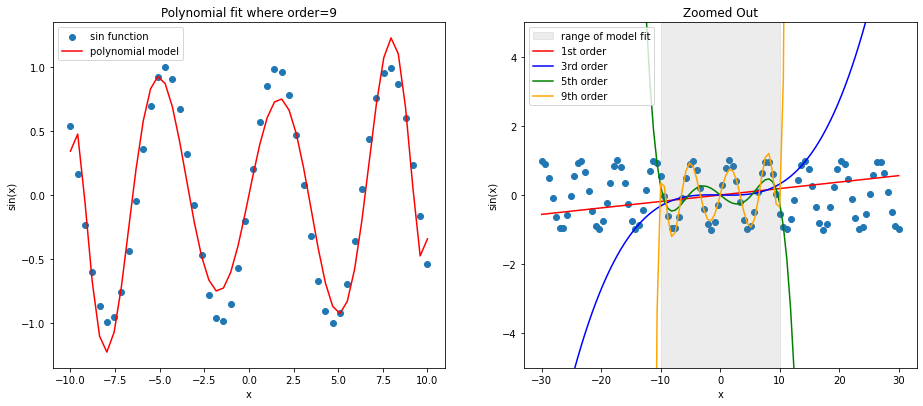

In [4]:
n = 9    # order of poly fit

x0 = np.linspace(-10,10,50)                
y0 = np.sin(x0)
polymodel = np.poly1d(np.polyfit(x0,y0,n)) #fit a polynomial model to the nth order

# plot the sin function with model fit
plt.subplot(121)                                     
plt.scatter(x0,y0, label='sin function');
plt.plot(x0, polymodel(x0), label='polynomial model',color= 'red')
plt.legend();plt.xlabel('x');plt.ylabel('sin(x)');plt.title('Polynomial fit where order=' + str(n))

x1 = np.linspace(-30,30,100) #use the same model on a greater range that exceeds the range of the model fit
y1 = np.sin(x1)

#same sin function zoomed out, highligting the range beyond which it fails
plt.subplot(122)                       
plt.scatter(x1,y1)
plt.axvspan(-10, 10, color='grey', alpha=0.15, label='range of model fit') # range of x values for the original model fit
plt.plot(x1 , np.poly1d(np.polyfit(x0,y0,1))(x1),label='1st order',color= 'red');plt.plot(x1 , np.poly1d(np.polyfit(x0,y0,3))(x1),label='3rd order',color= 'b')
plt.plot(x1 , np.poly1d(np.polyfit(x0,y0,5))(x1),label='5th order',color= 'g');plt.plot(x1 , np.poly1d(np.polyfit(x0,y0,n))(x1),label= str(n)+'th order',color= 'orange')
plt.ylim(-5,5);plt.xlabel('x');plt.ylabel('sin(x)');plt.legend();plt.title('Zoomed Out')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

* By changing 'n', you can see different model predictions with increasing complexity. The more complex and overfit to the original available data, the model fails almost immediately outside that range indicated by the grey outline. 
* Below you can see that the resulting error from generalizing the training data to a larger range quickly devolved and created a large mean squared error.

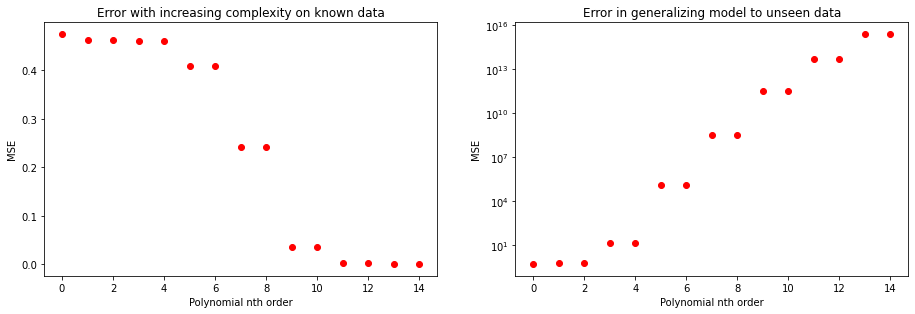

In [5]:
order = 15                    # show error for different polynomial fits to this order (#-1)
for i in range(order):         
    polymodel = np.poly1d(np.polyfit(x0,y0,i))            #the model from original -10 to 10 range
    err = metrics.mean_squared_error(y0,polymodel(x0))    #error of model to original x,y -10 to 10
    err1 = metrics.mean_squared_error(y1,polymodel(x1))   #error of above model to x1,y1 -30 to 30
    
    plt.subplot(121) 
    plt.scatter(i,err, color='r')
    plt.xlabel('Polynomial nth order');plt.ylabel('MSE');plt.title('Error with increasing complexity on known data')
    
    plt.subplot(122).set_yscale('log')
    plt.scatter(i,err1, color='r');
    plt.xlabel('Polynomial nth order');plt.ylabel('MSE');plt.title('Error in generalizing model to unseen data')
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0) 

* As expected, no matter the complexity or fit, models are ultimately limited to the range of values it was exposed to leading to overfit. 
* This will be true even with more sophisticated machine learning models that incorporate hyperparameter tuning 
* This is further expanded using a Random Forest model on subsurface data below

### 2. Model Generalization leading to overfit on Random Forest

Random Forest models are known to be robust and usually more difficult to overfit because it incorporates randomness and dissimilarities in its modeling process. It does this by forcing diversity it its splits by making them based on only a subset of the available data. However, in this workflow, I will be training on a subset of the data that was sorted based on production quality to see how it generalizes and demonstrate overfit.
##### Steps
1. Sort loaded data based on Production values
2. Use 20% of the dataset for training with the first 20% representing low production values and the last 20% representing high production values
3. There should be 5 'windows' of training data, view the distribution in feature space
4. See the prediction of the model based off that window
5. Compare mean squared errors on moving window of training datasets from low to high production

Random Forest is discussed below summarized from Professor Michael Pyrcz (@GeostatsGuy)'s workflow SubSurfuceDataAnalytics_EnsembleTrees.ipynb from [GeostatsGuy GitHub]: (https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_EnsembleTrees.ipynb) 

With random forest for each split only $\sqrt{m}$ predictor features are candidates. Note, in scikit learn the default is $\frac{m}{3}$. Use this hyperparameter to set to square root of the number of predictor features.
```python
max_features = 'sqrt'
```
* this forces tree diversity / decorrelates the trees
* recall the model variance reduced by averaging over multiple decision trees $Y = \frac{1}{B} \sum_{b=1}^{B} Y^b(X_1^b,...,X_m^b)$

Parameters to keep in mind

* `n_estimators` = number of trees 
* `max_depth` = maximum depth of the tree 
* `min_samples_split` = minimum number of samples to split a node 
* `max_features` = number of features to consider when making split

More detailed discussion on hyperparameter tuning and additional concepts can be found on both Ensemble Trees and Random Forest here in the link above

### Load Data

The following workflow applies the .csv file 'unconv_MV.csv', a synthetic dataset retrieved from Professor Michael Pyrcz at "https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV.csv" 

In [6]:
df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV.csv")
df = df.drop('WellIndex',axis = 1)   
df.describe().transpose()            # view statistical summary for errors

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.719480,15.077006,-10.500000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.003810,0.504978,-0.260000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


Making adjustments:
* make negative values = 0 
* use two features, (Porosity and Brittleness) for easy visualization
* sort dataframe by Production values 

In [7]:
num = df['Brittle']._get_numeric_data()                   # get the numerical values
num[num < 0] = 0                                          # truncate negative values to 0.0

df_sort = df.sort_values("Production").copy()             # sort dataframe from low to high production 

y = df_sort['Production'].copy()                          # y is response
X = df_sort[['Por','Brittle']].copy()                     # X is predictors

pormin = 5.0; pormax = 25.0                                 # set minumums and maximums for visualization 
brittlemin = 0.0; brittlemax = 100.0
prodmin = 0.0; prodmax = 13000.0

View histogram of the response feature data, Production (MCFPD). They will be divided into five sections with each containing 20% of the total data

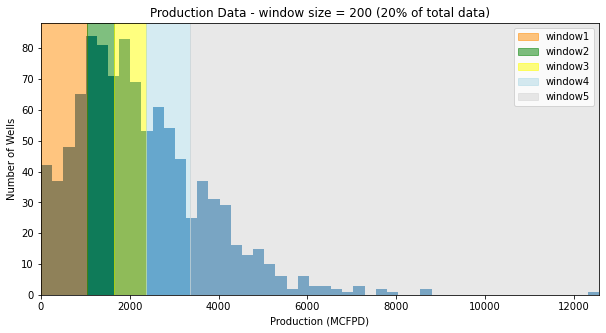

In [8]:
plt.figure(figsize=(10, 5))

plt.hist(df["Production"],bins=50) # see distribution of production values, this is the response feature
plt.axvspan(0, 1038.323, color='darkorange', alpha=0.5, label='window1') #x values here from the sorted dataframe
plt.axvspan(1038.323, 1653.324326, color='green', alpha=0.5,label='window2') #only applicable to this specific case
plt.axvspan(1653.324326, 2369.538579, color='yellow', alpha=0.5,label='window3')
plt.axvspan(2369.538579, 3353.632483, color='lightblue', alpha=0.5,label='window4')
plt.axvspan(3353.632483, 12568.644130, color='lightgrey', alpha=0.5,label='window5')
plt.xlabel('Production (MCFPD)'); plt.ylabel('Number of Wells');plt.xlim(0,12570);
plt.title('Production Data - window size = 200 (20% of total data)')
plt.legend()

* The goal is to have train/test split that is not random, but instead split by similar characteristics which in this case is production. This window is analagous to the x-range in the sin function above in that it is difficult to generalize outside its own specific range.

* As the figure shows, there is a skew in the data to the right. High production values cover a large range, but most of the data is centered around 2000 MCFPD.

Show the train test split in feature space based off the window 1-5 highlighted in the histogram

Window 1: Train on lowest production values


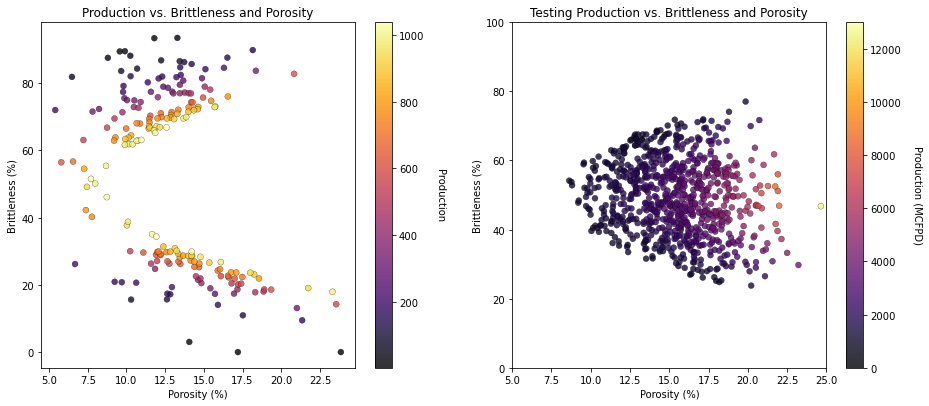

In [9]:
n = 1 #pick a number 1-5 which represents low-high window as shown in fig above

X_train, X_test, y_train, y_test, forest = production(n)

#plots from Professor Michael Pyrcz's functions above,
#training dataset
plt.subplot(121)
im = plt.scatter(X_train["Por"],X_train["Brittle"],s=None, c=y_train, marker=None, cmap=cmap, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Production vs. Brittleness and Porosity'); plt.xlabel('Porosity (%)'); plt.ylabel('Brittleness (%)')
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Production", rotation=270, labelpad=20)
#testing dataset
plt.subplot(122)
im = plt.scatter(X_test["Por"],X_test["Brittle"],s=None, c=y_test, marker=None, cmap=cmap, norm=None, vmin=prodmin, vmax=prodmax, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Testing Production vs. Brittleness and Porosity'); plt.xlabel('Porosity (%)'); plt.ylabel('Brittleness (%)')
plt.xlim(pormin,pormax); plt.ylim(brittlemin,brittlemax)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Production (MCFPD)", rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

Show visualization of model and predictions for each of the five different training windows. All five windows will be run to view all at once.

Window 1: Train on lowest production values
Mean Squared Error on Training =  4617744.52 , Variance Explained = 0.01


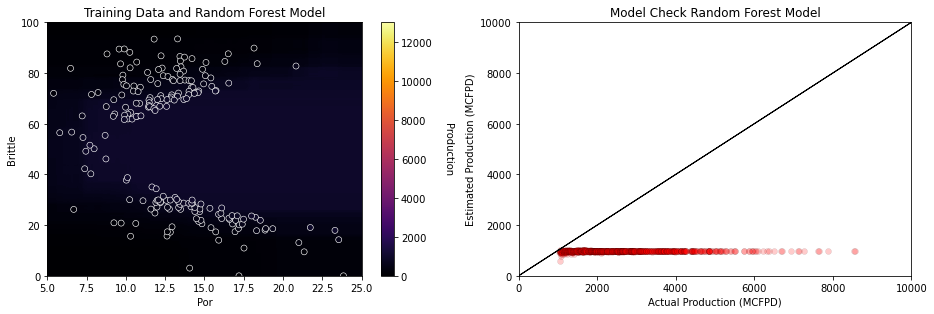

Window 2: Train on low-med production
Mean Squared Error on Training =  2975086.6 , Variance Explained = 0.18


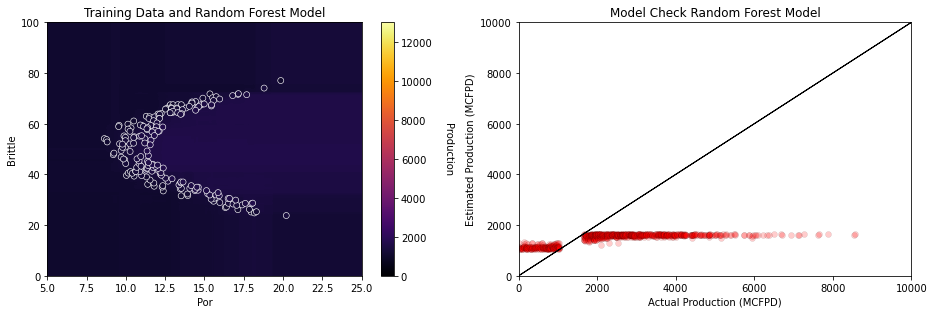

Window 3: Train on medium production values
Mean Squared Error on Training =  2077052.87 , Variance Explained = 0.25


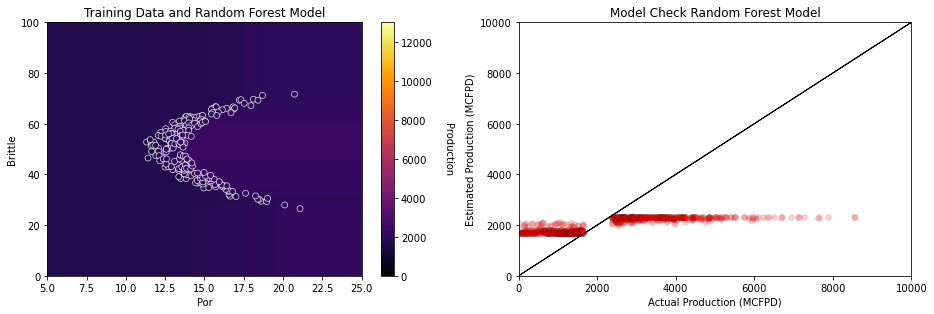

Window 4: Train on med-high production
Mean Squared Error on Training =  2008089.31 , Variance Explained = 0.32


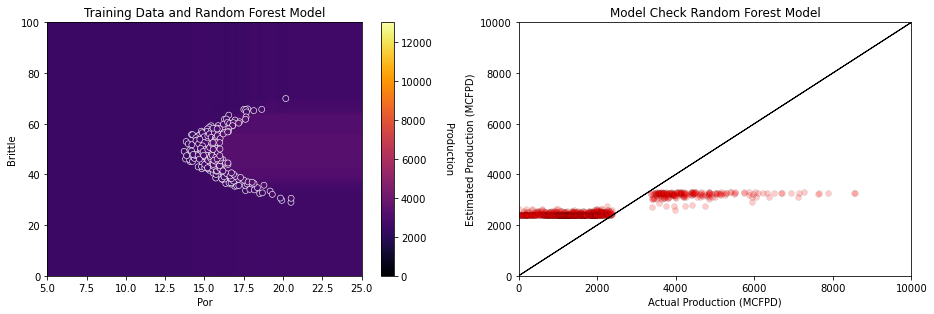

Window 5: Train on highest production values
Mean Squared Error on Training =  4050521.37 , Variance Explained = -0.06


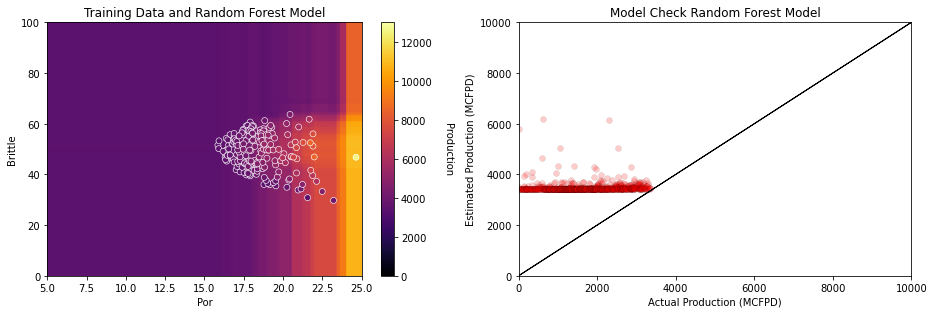

In [10]:
n = [1,2,3,4,5]      # where 1 is the first 20% of values, then the next 20, and so forth

for i in n:
    X_train, X_test, y_train, y_test, forest = production(i) # function up above for assigning train test split
    #fit a random forest 
    forest = RandomForestRegressor(max_depth=10, random_state=2,n_estimators=100) 
    forest.fit(X_train,y_train)
    
    #plots are from Professor Michael Pyrcz's functions above
    plt.subplot(121)                  # predict with the model over the predictor feature space and visualize
    visualize_model(forest,X_train["Por"],pormin,pormax,X_train["Brittle"],brittlemin,brittlemax,y_train,prodmin,prodmax,'Training Data and Random Forest Model')
    plt.subplot(122)                  # perform cross validation with withheld testing data
    check_model(forest,X_test["Por"],X_test["Brittle"],y_test,'Model Check Random Forest Model')
    
    #undo hashtag to see missing training data
    #actual = forest.predict(np.c_[X_train["Por"],X_train["Brittle"]]) 
    #plt.scatter(y_train,actual, color = 'black', alpha = .05)

    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0) 
    plt.show()


* It is evident that training on low production values severely underestimates real production values and training on high production values overestimates production values because it is overfit to the training data.

* The training data is indicated by the gap in the Model Check plot. It follows the 45 degree line, followed by the. failure in generalization much like the sin function.

* This kind of bias may occur if the data available was only representative of a specific geospatial area that had similar production quality.

The figure below shows how different training sizes would affect the mean squared error.

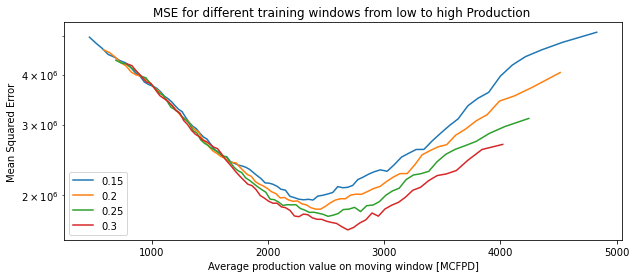

In [11]:
plt.figure(figsize=(10, 4)) 

for t in np.arange(.15, .35, .05):      #t = training size from 15%, 20%, 25%, 30%
    width = int(1000*t)                 #width = size of moving window/training dataset dictated by 't'
    prodx = []                          #instantiate average production value of y_train
    msq_err = []                        #instantiate MSE of test vs prediction
    for w in range(0,(1001-width),10):  #slide training windows of different sizes through all data 
        X_train = X.iloc[w:width+w]           #ex. if t=.15 and w=10 then X.iloc[10:160] i.e. 150 values from 10                      
        X_test =  pd.concat([X.iloc[0:w],X.iloc[width+w:]])         #ex. cont. X.iloc[0:10],X.iloc[160:]              
        y_train = y.iloc[w:width+w]                                 #ex. cont. y.iloc[10:160]
        y_test = pd.concat([y.iloc[0:w],y.iloc[width+w:]])          #ex. cont. y.iloc[0:10],y.iloc[160:]
        #fit random forest model
        Forest = RandomForestRegressor(max_depth=10, random_state=2,n_estimators=100)
        Forest.fit(X_train,y_train)
        
        msq_err.append(metrics.mean_squared_error(y_test,Forest.predict(X_test))) #error of prediction
        prodx.append(y_train.mean())                                              #mean value for the training window
    #plt.figure(figsize=(10, 4))      
    plt.plot(prodx,msq_err, label = round(t,2))
    plt.yscale("log");plt.legend();plt.title('MSE for different training windows from low to high Production ')
    plt.xlabel('Average production value on moving window [MCFPD]');plt.ylabel('Mean Squared Error')

* The MSE seems to be just about the same for all training sizes for low production values, coming to a minumum between 2000-3000 MCFPD, and diverging at high production values. This is expected since the production histogram showed a right skew with the center sitting at around 2000 MCFPD. 

* At high production values, which did not have as many data values, MSE is only minimized by having a bigger training size. 

* Ideally, hyperparameters should be tuned after an initial model fit as mentioned above. In this workflow however, the overfit from the train test split was too great, the hyper parameters did little to help the MSE. 

* The key takeaway is that no matter how good the model, they can always be overfit if the data is not representative. Depending on the type of data, modelers should be aware of when it makes sense to generalize models.


I hope this was helpful,

*Angela Luciano*

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
